In [1]:
import os
num_threads = "4"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

In [2]:
import torch
from torchdiffeq import odeint
import numpy as np
import scipy as sp
import sys
sys.path.append("../../src")
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.float32)
import importlib
import fm
import torchsde
importlib.reload(fm)

/home/stephenz/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


<module 'fm' from '/data/gpfs/projects/punim0638/stephenz/nonequilibriumSBP/notebooks/gaussian/../../src/fm.py'>

In [3]:
N = 128
dim = 10
seed = 1

In [4]:
data = torch.load(f"data_seed_{seed}_dim_{dim}_N_{N}.pkl")
x0, x1 = data['x0'], data['x1']
A, mu = data['A'], data['mu']
d, sigma = data['d'], data['sigma']
U = data['U']
ts = torch.tensor([0., 1.])

In [5]:
U.shape

torch.Size([10, 2])

In [6]:
otfm = fm.LinearEntropicOTFM(torch.vstack([x0, x1]), 
                      torch.hstack([torch.full((x0.shape[0], ), 0), torch.full((x0.shape[0], ), 1)]), 
                      ts = ts,
                      sigma = sigma,
                      A = A,
                      mu = mu,
                      T = 2,
                      dim = d,
                      device = torch.device('cpu')
                      )
otfm_null = fm.EntropicOTFM(torch.vstack([x0, x1]), 
                      torch.hstack([torch.full((x0.shape[0], ), 0), torch.full((x0.shape[0], ), 1)]), 
                      ts = ts,
                      sigma = sigma,
                      T = 2,
                      dim = d,
                      device = torch.device('cpu')
                      )

In [7]:
s_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
s_model.load_state_dict(torch.load(f"weights/otfm_score_seed_{seed}_dim_{dim}_N_{N}.pt"))
v_model = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
v_model.load_state_dict(torch.load(f"weights/otfm_flow_seed_{seed}_dim_{dim}_N_{N}.pt"))

s_model_null = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
s_model_null.load_state_dict(torch.load(f"weights/otfm_null_score_seed_{seed}_dim_{dim}_N_{N}.pt"))
v_model_null = fm.MLP(d = d, hidden_sizes = [64, 64, 64], time_varying=True, activation = torch.nn.ReLU)
v_model_null.load_state_dict(torch.load(f"weights/otfm_null_flow_seed_{seed}_dim_{dim}_N_{N}.pt"))

<All keys matched successfully>

In [8]:
def _project(sb_means, sb_vars, S_t, d_sb_means, U):
    U_expanded = U.unsqueeze(0).expand(sb_means.shape[0], *U.shape)
    sb_means_proj = torch.bmm(sb_means.mT, U_expanded).squeeze()
    sb_vars_proj = torch.bmm(U_expanded.mT, torch.bmm(sb_vars, U_expanded))
    S_t_proj = torch.bmm(U_expanded.mT, torch.bmm(S_t, U_expanded))
    d_sb_means_proj = torch.bmm(d_sb_means.mT, U_expanded).squeeze()
    return sb_means_proj, sb_vars_proj, S_t_proj, d_sb_means_proj

def _project_traj(xs, U):
    return torch.bmm(xs, U.unsqueeze(0).expand(xs.shape[0], *U.shape));

_v, _s, what = v_model, s_model, "OU"
# _v, _s, what = v_model_null, s_model_null, "BM"
xlims = (-5, 5)
ylims = (-8, 10)

x0_proj, x1_proj = x0 @ U, x1 @ U
sde = fm.SDE(lambda t, x: _v(t, x) + sigma**2 / 2 * _s(t, x), sigma)
_T = 100
with torch.no_grad():
    xs_sde = torchsde.sdeint(sde, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
    xs_ode = odeint(lambda t, x: _v(t, x), torch.tensor(x0), torch.linspace(0, 1, _T))
xs_sde_proj = _project_traj(xs_sde, U)
xs_ode_proj = _project_traj(xs_ode, U)

/tmp/ipykernel_181536/2906773406.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde = torchsde.sdeint(sde, torch.tensor(x0), torch.linspace(0, 1, _T), method = "euler")
/tmp/ipykernel_181536/2906773406.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_ode = odeint(lambda t, x: _v(t, x), torch.tensor(x0), torch.linspace(0, 1, _T))


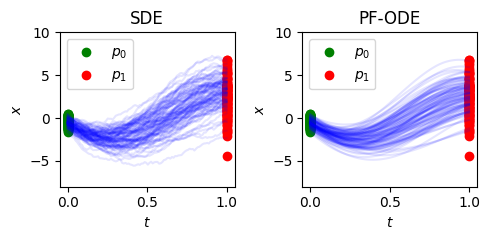

In [10]:
k = 1
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
plt.plot(torch.linspace(0, 1, _T), xs_sde_proj[:, range(100), k] , color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0 @ U[:, k]), x0 @ U[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1 @ U[:, k]), x1 @ U[:, k], c = 'red', label = "$p_1$")
plt.title("SDE")
plt.legend()
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.ylim(*ylims)
plt.subplot(1, 2, 2)
plt.plot(torch.linspace(0, 1, _T), xs_ode_proj[:, range(100), k], color = 'blue', alpha = 0.1);
plt.scatter(torch.zeros_like(x0 @ U[:, k]), x0 @ U[:, k], c = 'green', label = "$p_0$")
plt.scatter(torch.ones_like(x1 @ U[:, k]), x1 @ U[:, k], c = 'red', label = "$p_1$")
plt.legend()
plt.title("PF-ODE")
plt.xlabel("$t$"); plt.ylabel("$x$")
plt.ylim(*ylims)
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_1d_v_time_seed_{seed}_dim_{dim}_N_{N}.pdf")

In [11]:
xlims = (-5, 5)
ylims = (-7.5, 7.5)
x = np.linspace(*xlims, 100)
y = np.linspace(*ylims, 100)
X, Y = np.meshgrid(x, y)
u, v = U.numpy().T @ (A.numpy() @ ((U.numpy() @ np.vstack([X.flatten(), Y.flatten()])) - mu.numpy()[:, None]))
u = u.reshape(X.shape)
v = v.reshape(X.shape)
# don't plot origin
_idx = (X**2 < 1) & (Y**2 < 1)
u[_idx] = 0
v[_idx] = 0

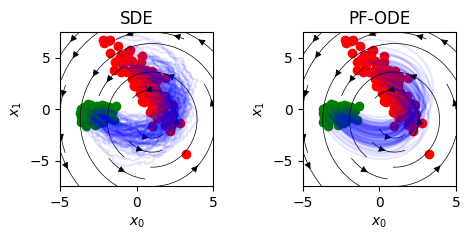

In [12]:
plt.figure(figsize = (5, 2.5))
plt.subplot(1, 2, 1)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
plt.plot(xs_sde_proj[:, range(100), 0], xs_sde_proj[:, range(100), 1], color = 'blue', alpha = 0.1);
plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green', label = "$p_0$")
plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red', label = "$p_1$")
# plt.legend()
plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
plt.title("SDE")
plt.xlim(*xlims); plt.ylim(*ylims)
plt.subplot(1, 2, 2)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
plt.plot(xs_ode_proj[:, range(100), 0], xs_ode_proj[:, range(100), 1], color = 'blue', alpha = 0.1);
plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green', label = "$p_0$")
plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red', label = "$p_1$")
# plt.legend()
plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
plt.title("PF-ODE")
plt.xlim(*xlims); plt.ylim(*ylims)
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_2d_seed_{seed}_dim_{dim}_N_{N}.pdf")

/tmp/ipykernel_181536/603858309.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_sigma[_sigma] = torchsde.sdeint(sde, torch.tensor(x0, dtype = torch.float32), torch.linspace(0, 1, _T), method = "euler")


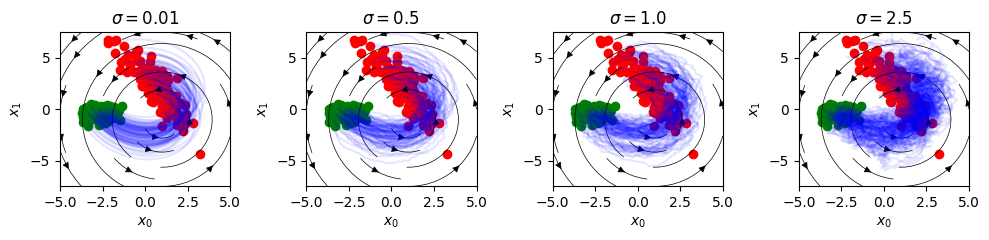

In [13]:
# varying noise level in forward simulation
xs_sde_sigma = {}
for _sigma in [0.01, 0.5, 1.0, 2.5]:
    sde = fm.SDE(lambda t, x: _v(t, x) + _sigma**2 / 2 * _s(t, x), _sigma)
    _T = 100
    with torch.no_grad():
        xs_sde_sigma[_sigma] = torchsde.sdeint(sde, torch.tensor(x0, dtype = torch.float32), torch.linspace(0, 1, _T), method = "euler")

plt.figure(figsize = (10, 2.5))
for i, (_sigma, _xs) in enumerate(xs_sde_sigma.items()):
    _xs_proj = _project_traj(_xs, U)
    plt.subplot(1, 4, i+1)
    plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1)
    plt.plot(_xs_proj[:, range(100), 0], _xs_proj[:, range(100), 1], color = 'blue', alpha = 0.1);
    plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green')
    plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red')
    plt.xlabel("$x_0$"); plt.ylabel("$x_1$")
    plt.xlim(*xlims); plt.ylim(*ylims)
    plt.title(f"$\\sigma = {_sigma}$")
    plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_2d_var_noise_seed_{seed}_dim_{dim}_N_{N}.pdf")

In [14]:
t = torch.linspace(0, 1, 25)
sde = fm.SDE(lambda t, x: v_model(t, x) + sigma**2 / 2 * s_model(t, x), sigma)
sde_null = fm.SDE(lambda t, x: v_model_null(t, x) + sigma**2 / 2 * s_model_null(t, x), sigma)
with torch.no_grad():
    xs_sde = torchsde.sdeint(sde, torch.tensor(x0), t, method = "euler")
    xs_sde_null = torchsde.sdeint(sde_null, torch.tensor(x0), t, method = "euler")
xs_sde_proj = torch.bmm(xs_sde, U.unsqueeze(0).expand(xs_sde.shape[0], *U.shape));
xs_sde_null_proj = torch.bmm(xs_sde_null, U.unsqueeze(0).expand(xs_sde_null.shape[0], *U.shape));

/tmp/ipykernel_181536/807660744.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde = torchsde.sdeint(sde, torch.tensor(x0), t, method = "euler")
/tmp/ipykernel_181536/807660744.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_null = torchsde.sdeint(sde_null, torch.tensor(x0), t, method = "euler")


In [15]:
importlib.reload(fm)
mean0, mean1 = data['mean0'], data['mean1']
mean0_proj, mean1_proj = mean0 @ U, mean1 @ U
var0, var1 = data['var0'], data['var1']
var0_proj, var1_proj = U.T @ var0 @ U, U.T @ var1 @ U

gsb = fm.GaussianOUSB(otfm.bm, otfm)
sb_means, sb_vars, S_t, d_sb_means = gsb.evaluate(t, mean0, mean1, var0, var1)
sb_means_proj, sb_vars_proj, S_t_proj, d_sb_means_proj = _project(sb_means, sb_vars, S_t, d_sb_means, U)
xs_sde_proj = _project_traj(xs_sde, U)
x0_proj, x1_proj = x0 @ U, x1 @ U
_x = torch.tensor(np.vstack([X.flatten(), Y.flatten()]), dtype = torch.float32)
vs = [d_sb_means[i] + (S_t[i].T @ torch.linalg.pinv(sb_vars[i])) @ ((U @ _x) - sb_means[i]) for i in range(len(t))]
vs_proj = [U.T @ v for v in vs]

In [16]:
_otfm_null = fm.LinearEntropicOTFM(torch.vstack([x0, x1]), 
                      torch.hstack([torch.full((x0.shape[0], ), 0), torch.full((x0.shape[0], ), 1)]), 
                      ts = ts,
                      sigma = sigma,
                      A = 0*A,
                      mu = 0*mu,
                      T = 2,
                      dim = d,
                      device = torch.device('cpu')
                      )

gsb_null = fm.GaussianOUSB(_otfm_null.bm, _otfm_null)
sb_means_null, sb_vars_null, S_t_null, d_sb_means_null = gsb_null.evaluate(t, mean0, mean1, var0, var1)
sb_means_proj_null, sb_vars_proj_null, S_t_proj_null, d_sb_means_proj_null = _project(sb_means_null, sb_vars_null, S_t_null, d_sb_means_null, U)
xs_sde_proj_null = _project_traj(xs_sde_null, U)
vs_null = [d_sb_means_null[i] + (S_t_null[i].T @ torch.linalg.pinv(sb_vars_null[i])) @ ((U @ _x) - sb_means_null[i]) for i in range(len(t))]
vs_proj_null = [U.T @ v for v in vs_null]

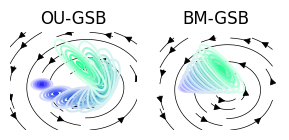

In [17]:
import matplotlib

def get_cmap(solid_color):
    cdict = {
        'red':   [(0.0, 1.0, 1.0),  # Start at white (1.0, 1.0, 1.0)
                  (1.0, solid_color[0], solid_color[0])],  # End at solid color

        'green': [(0.0, 1.0, 1.0),
                  (1.0, solid_color[1], solid_color[1])],

        'blue':  [(0.0, 1.0, 1.0),
                  (1.0, solid_color[2], solid_color[2])]
    }
    return matplotlib.colors.LinearSegmentedColormap('WhiteToBlue', cdict)


from scipy.stats import multivariate_normal
x = np.linspace(*xlims, 100)
y = np.linspace(*ylims, 100)
X, Y = np.meshgrid(x, y)
_X = np.vstack([X.reshape(-1), Y.reshape(-1)])
pos = np.dstack((X, Y))

def plot_bivariate(mean, cov, cm, **kwargs):
    rv = multivariate_normal(mean, cov)
    Z = rv.pdf(pos)
    plt.contour(X, Y, Z, levels=5, cmap=cm, **kwargs)

plt.figure(figsize = (3, 1.5))
plt.subplot(1, 2, 1)
for i in range(0, len(t), 3):
    cm = get_cmap(matplotlib.cm.winter(t[i].item()))
    plot_bivariate(sb_means_proj[i].flatten(), sb_vars_proj[i].reshape(2, 2), cm = cm)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1, zorder = -100)
plt.xlim(*xlims); plt.ylim(*ylims)
plt.xlabel("$x_0$"); plt.ylabel("$x_1$"); plt.axis('off')
plt.title("OU-GSB")
plt.subplot(1, 2, 2)
for i in range(0, len(t), 3):
    cm = get_cmap(matplotlib.cm.winter(t[i].item()))
    plot_bivariate(sb_means_proj_null[i].flatten(), sb_vars_proj_null[i].reshape(2, 2), cm = cm)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1, zorder = -100)
plt.title("BM-GSB")
plt.xlabel("$x_0$"); plt.ylabel("$x_1$"); plt.axis('off')
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_2d_gaussian_fm_seed_{seed}_dim_{dim}_N_{N}.pdf")

In [18]:
torch.vmap(lambda x: (x - x.T).norm())(torch.bmm(S_t_null.mT, torch.linalg.pinv(sb_vars_null)))
torch.vmap(lambda x: x.norm())(torch.bmm(S_t.mT, torch.linalg.pinv(sb_vars)))

tensor([ 5.2448,  5.2998,  5.3583,  5.4214,  5.4903,  5.5668,  5.6525,  5.7494,
         5.8600,  5.9870,  6.1340,  6.3055,  6.5071,  6.7462,  7.0330,  7.3808,
         7.8087,  8.3437,  9.0259,  9.9164, 11.1131, 12.7830, 15.2359, 19.1195,
        26.0592])

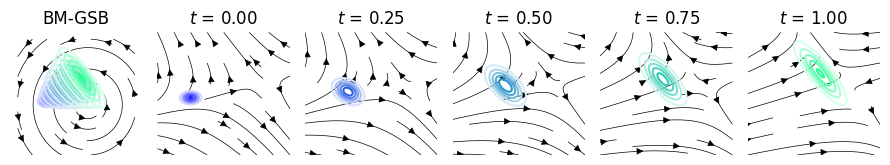

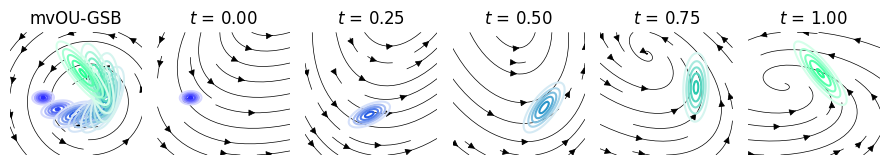

In [20]:
plt.figure(figsize = (9, 1.75))
plt.subplot(1, 6, 1)
for i in range(0, len(t), 3):
    cm = get_cmap(matplotlib.cm.winter(t[i].item()))
    plot_bivariate(sb_means_proj_null[i].flatten(), sb_vars_proj_null[i].reshape(2, 2), cm = cm)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1, zorder = -100)
plt.title("BM-GSB")
plt.xlabel("$x_0$"); plt.ylabel("$x_1$"); plt.axis('off')
for j, i in enumerate(range(0, len(t), 6)):
    plt.subplot(1, 6, j+2)
    plt.streamplot(X, Y, vs_proj_null[i][0, :].reshape(X.shape), vs_proj_null[i][1, :].reshape(X.shape), density=0.3, color='k', linewidth=0.5, arrowsize=1)
    plot_bivariate(sb_means_proj_null[i].flatten(), sb_vars_proj_null[i].reshape(2, 2), cm = get_cmap(matplotlib.cm.winter(t[i].item())))
    # plt.arrow(sb_means_proj[i, 0].item(), sb_means_proj[i, 1].item(), 0.25*d_sb_means_proj[i, 0].item(), 0.25*d_sb_means_proj[i, 1].item(), head_width=0.2, head_length=0.3, fc='blue', ec='blue', zorder = 100)
    plt.xlim(*xlims); plt.ylim(*ylims)
    plt.axis("off")
    plt.title(f"$t$ = {t[i]:.2f}")
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_2d_gaussian_marginals_BM_seed_{seed}_dim_{dim}.pdf")

plt.figure(figsize = (9, 1.75))
plt.subplot(1, 6, 1)
for i in range(0, len(t), 3):
    cm = get_cmap(matplotlib.cm.winter(t[i].item()))
    plot_bivariate(sb_means_proj[i].flatten(), sb_vars_proj[i].reshape(2, 2), cm = cm)
plt.streamplot(X, Y, u, v, density=0.3, color='k', linewidth=0.5, arrowsize=1, zorder = -100)
plt.xlim(*xlims); plt.ylim(*ylims)
plt.xlabel("$x_0$"); plt.ylabel("$x_1$"); plt.axis('off')
plt.title("mvOU-GSB")
for j, i in enumerate(range(0, len(t), 6)):
    plt.subplot(1, 6, j+2)
    plt.streamplot(X, Y, vs_proj[i][0, :].reshape(X.shape), vs_proj[i][1, :].reshape(X.shape), density=0.3, color='k', linewidth=0.5, arrowsize=1)
    plot_bivariate(sb_means_proj[i].flatten(), sb_vars_proj[i].reshape(2, 2), cm = get_cmap(matplotlib.cm.winter(t[i].item())))
    # plt.arrow(sb_means_proj[i, 0].item(), sb_means_proj[i, 1].item(), 0.25*d_sb_means_proj[i, 0].item(), 0.25*d_sb_means_proj[i, 1].item(), head_width=0.2, head_length=0.3, fc='blue', ec='blue', zorder = 100)
    plt.xlim(*xlims); plt.ylim(*ylims)
    plt.axis("off")
    plt.title(f"$t$ = {t[i]:.2f}")
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_{what}_2d_gaussian_marginals_OU_seed_{seed}_dim_{dim}.pdf")

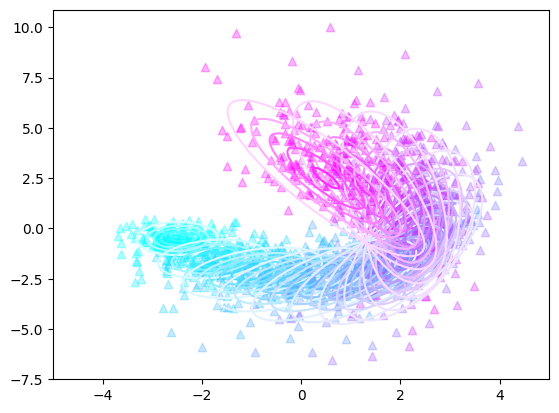

In [21]:
for i in range(0, len(t), 2):
    cm = get_cmap(matplotlib.cm.cool(t[i].item()))
    plt.scatter(xs_sde_proj[i][:, 0], xs_sde_proj[i][:, 1], color = matplotlib.cm.cool(t[i].item()), alpha = 0.3, marker = '^', label = f"Sampled: t = {t[i]}")
    plot_bivariate(sb_means_proj[i].flatten(), sb_vars_proj[i].reshape(2, 2), cm = cm)

In [22]:
sb_means, sb_vars, S_t, d_sb_means = gsb.evaluate(gsb.bm.ts, mean0, mean1, var0, var1)
sb_means_proj, sb_vars_proj, S_t_proj, d_sb_means_proj = _project(sb_means, sb_vars, S_t, d_sb_means, U)

def _F(t, x):
    _S_t = gsb.bm.interp(S_t, t)
    _var_t = gsb.bm.interp(sb_vars, t)
    _mean_t = gsb.bm.interp(sb_means, t)
    _dmean_t = gsb.bm.interp(d_sb_means, t)
    return _dmean_t + _S_t.T @ torch.linalg.pinv(_var_t) @ (x - _mean_t)

sde_gt = fm.SDE(_F, sigma)
with torch.no_grad():
    xs_sde_gt = torchsde.sdeint(sde, torch.tensor(x0), t, method = "euler")
xs_sde_gt_proj = _project_traj(xs_sde_gt, U)

/tmp/ipykernel_181536/4291516909.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xs_sde_gt = torchsde.sdeint(sde, torch.tensor(x0), t, method = "euler")


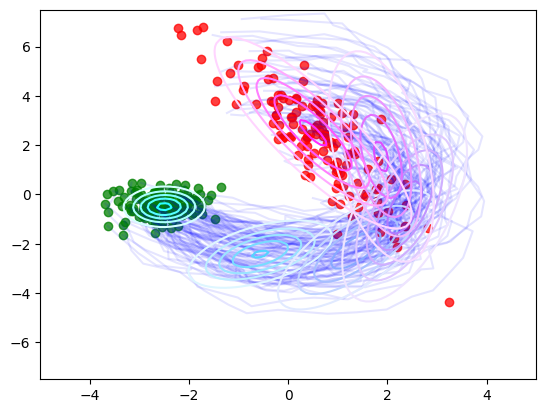

In [23]:
plt.plot(xs_sde_gt_proj[:, range(100), 0], xs_sde_gt_proj[:, range(100), 1], color = 'blue', alpha = 0.1);
for i in list(range(0, len(gsb.bm.ts), 5)) + [len(gsb.bm.ts)-1, ]:
    cm = get_cmap(matplotlib.cm.cool(gsb.bm.ts[i].item()))
    plot_bivariate(sb_means_proj[i].flatten(), sb_vars_proj[i].reshape(2, 2), cm = cm)
plt.scatter(x0_proj[:, 0], x0_proj[:, 1], c = 'green', alpha = 0.75)
plt.scatter(x1_proj[:, 0], x1_proj[:, 1], c = 'red', alpha = 0.75)

(-7.5, 7.5)

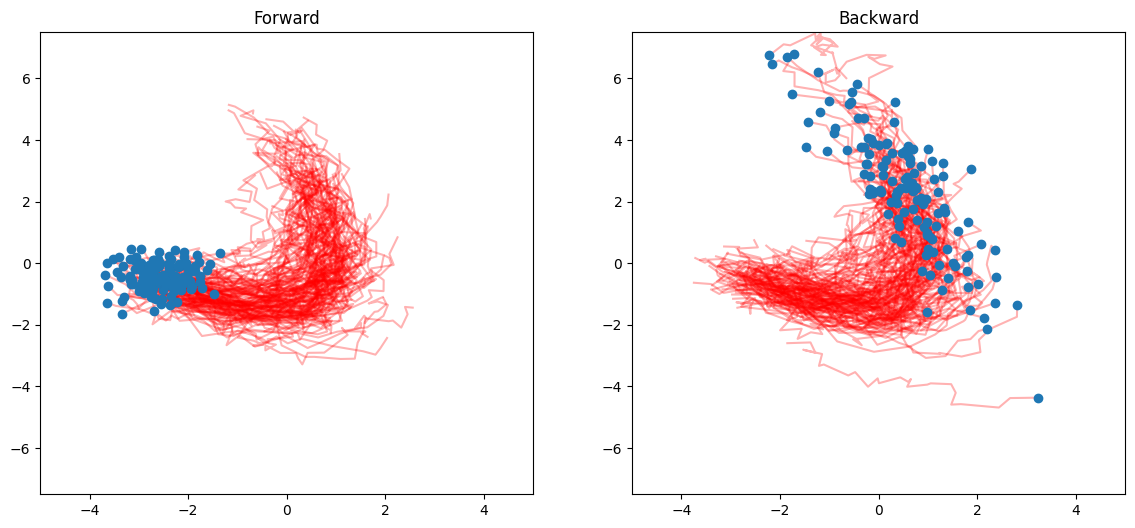

In [25]:
# Load results from IPFP (Vargas et al., 2021)
result = torch.load(f"weights/gp_sinkhorn_seed_{seed}_dim_{dim}_N_{N}.pkl")
fig, (ax1, ax2) =  plt.subplots(1, 2,figsize=(14,6))
M = result[-1][1][..., :-1] @ U.double()
M2 = result[-1][3][..., :-1] @ U.double()
for i in range(len(M)): 
    μ10 = M[i,:,0].detach()
    μ11 = M[i,:,1].detach()
    μ20 = M2[i,:,0].detach()
    μ21 = M2[i,:,1].detach()
    ax1.plot(μ10, μ11, alpha=.3, color="red")
    ax2.plot(μ20, μ21, alpha=.3, color="red")
ax1.scatter(M[:,0,0].detach(),M[:,0,1].detach(), zorder = 100)
ax2.scatter(M2[:,0,0].detach(),M2[:,0,1].detach(), zorder = 100)
ax1.set_title("Forward")
ax2.set_title("Backward")
ax1.set_xlim(*xlims); ax1.set_ylim(*ylims)
ax2.set_xlim(*xlims); ax2.set_ylim(*ylims)

In [26]:
import pandas as pd
import glob
import seaborn as sb
files = glob.glob(f"eval/eval_seed_*_dim_*_N_{N}.csv")
seeds = [int(os.path.basename(f).split("_")[2]) for f in files]
dims = [int(os.path.basename(f).split("_")[4]) for f in files]
df = pd.concat([pd.DataFrame(pd.read_csv(f, index_col = 0).iloc[:, 1:].mean(0)).T.assign(seed=s).assign(dim=d).assign(file=f) for (f, s, d) in zip(files, seeds, dims)])
_df = pd.concat([pd.DataFrame(pd.read_csv(f"eval/eval_nlsb_seed_{s}_dim_{d}_N_{N}.csv", index_col = 0).iloc[:, 1:].mean(0)).T for (f, s, d) in zip(files, seeds, dims)])
df = pd.concat([df, _df], axis = 1)

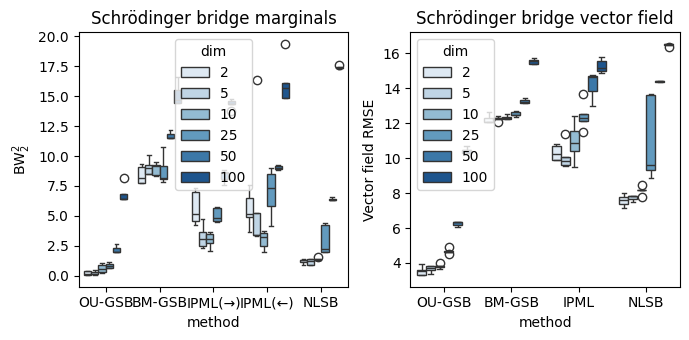

In [28]:
_df1 = df.melt(id_vars = ['seed', 'dim', 'file'], value_vars=['OU_EOT_BW', 'EOT_BW', 'GP_sinkhorn_fwd_BW', 'GP_sinkhorn_rev_BW', 'NLSB_BW', ])
_df1 = _df1.replace({'variable' : {'OU_EOT_BW' : 'OU-GSB', 
                                'EOT_BW' : 'BM-GSB', 
                                'GP_sinkhorn_fwd_BW' : 'IPML(→)', 
                                'GP_sinkhorn_rev_BW' : 'IPML(←)', 
                                'NLSB_BW' : 'NLSB', 
                                  }})
_df1=_df1.rename(columns={'variable' : 'method',})
_df1.dim = _df1.dim.astype('category')
plt.figure(figsize = (7, 3.5))
plt.subplot(1, 2, 1)
sb.boxplot(_df1, x = "method", y = "value", hue = "dim", palette = "Blues")
plt.title("Schrödinger bridge marginals")
plt.ylabel("$\\rm{BW}_2^2$")

_df2 = df.melt(id_vars = ['seed', 'dim', 'file'], value_vars=['OU_EOT_vf', 'EOT_vf', 'GP_sinkhorn_vf', 'NLSB_vf', ])
_df2 = _df2.replace({'variable' : {'OU_EOT_vf' : 'OU-GSB', 
                                   'EOT_vf' : 'BM-GSB',
                                   'GP_sinkhorn_vf' : 'IPML',
                                   'NLSB_vf' : 'NLSB', 
                                  }})
_df2=_df2.rename(columns={'variable' : 'method',})
_df2.dim = _df2.dim.astype('category')
plt.subplot(1, 2, 2)
sb.boxplot(_df2, x = "method", y = "value", hue = "dim", palette = "Blues")
plt.ylabel("Vector field RMSE")
plt.title("Schrödinger bridge vector field")
plt.tight_layout()
# plt.savefig(f"../../figures/SB_Gaussian_benchmarking.pdf")